## **Training a Bayesian Neural Network**

In the present notebook we train a baseline Bayesian Neural Network (BNN).

We train for 150 epochs with a learning rate of $\eta = 0.2$

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse

# Colab in order to download files
from google.colab import files


# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [2]:
# Mount drive to upload/download the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load data**

In [3]:
# Images
X_train = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_train.npy"))
X_val = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_val.npy"))

# Labels
y_train = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_train.npy"))
y_val = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_val.npy"))

**Scale**

Here we scale the labels.

In [4]:
scaler = StandardScaler()

# Rescale the labels
scaler.fit(y_train)
y_train_sc = scaler.transform(y_train)
y_val_sc = scaler.transform(y_val)

In [5]:
# Define basic numbers
IMAGE_SHAPE = [64,64,1]
NUM_TRAIN_EXAMPLES = 150000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 10000
NUM_CLASSES = 5

**Define KL divergence function**

In [6]:
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

**Build the Bayesian Deep Learning model**



In [7]:
# Bayesian DeepBFit in functional form
model_input = Input(shape=(64,64,1))
# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(model_input)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 2nd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 8, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 3rd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 16, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 4th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 32, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 5th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 64, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)                    
# =========================================
# =========================================
x = keras.layers.Flatten()(x)
# =========================================
# =========================================
x = tfp.layers.DenseFlipout(
          units = 1024,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
#x = tfp.layers.DenseFlipout(
#          units = 512,
#          kernel_divergence_fn=kl_divergence_function,
#          activation=tf.nn.relu)(x)
distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(5))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=5)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [8]:
# Define loss
def negloglik(y_true, y_pred):    
    return -tf.reduce_mean(y_pred.log_prob(y_true))


# Define the optimizer 
optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.2, rho=0.98)
model.compile(optimizer,
              loss=negloglik,
              metrics=['mae'],experimental_run_tf_function=False)

In [9]:
EPOCHS = 150

model.fit(x=X_train, y=y_train_sc,
          epochs=EPOCHS, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val_sc))

Epoch 1/150
2344/2344 [==============================] - 46s 12ms/step - loss: 11.2080 - mae: 1.0673 - val_loss: 10.2845 - val_mae: 0.9055
Epoch 2/150
2344/2344 [==============================] - 27s 11ms/step - loss: 8.8654 - mae: 0.7901 - val_loss: 8.2775 - val_mae: 0.7022
Epoch 3/150
2344/2344 [==============================] - 27s 11ms/step - loss: 7.9067 - mae: 0.6757 - val_loss: 7.6010 - val_mae: 0.6493
Epoch 4/150
2344/2344 [==============================] - 27s 11ms/step - loss: 7.4434 - mae: 0.6363 - val_loss: 7.2520 - val_mae: 0.6270
Epoch 5/150
2344/2344 [==============================] - 27s 11ms/step - loss: 7.0820 - mae: 0.6084 - val_loss: 7.0211 - val_mae: 0.5973
Epoch 6/150
2344/2344 [==============================] - 27s 11ms/step - loss: 6.7720 - mae: 0.5853 - val_loss: 6.7433 - val_mae: 0.5803
Epoch 7/150
2344/2344 [==============================] - 27s 11ms/step - loss: 6.5095 - mae: 0.5665 - val_loss: 6.4230 - val_mae: 0.5548
Epoch 8/150
2344/2344 [================

**SAVE THE MODEL WEIGHTS**

Now let's save the model weights, to be used when evaluating the model or predicting on new, unseen examples.

In [10]:
model.save_weights('/content/drive/My Drive/BNN_Final_Codes/BNN_weights.h5',overwrite=True)

**Plot training history**

In [11]:
history_dict = model.history.history

In [12]:
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

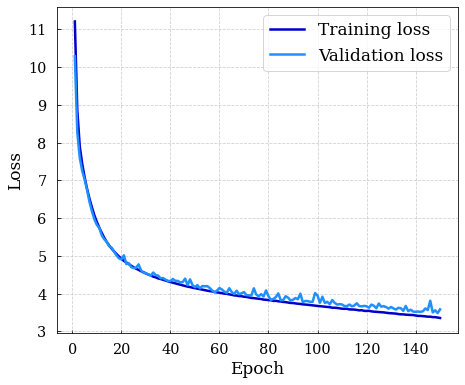

In [13]:
Epochs_sp = np.arange(1,EPOCHS+1,1)

# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Loss
plt.plot(Epochs_sp, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
plt.plot(Epochs_sp, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# ==========================================
# ==========================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epoch', fontsize=17);plt.ylabel('Loss',fontsize=17)
plt.legend(frameon=True, loc='upper right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

#plt.xlim(20,)
#plt.ylim(0,0.4)
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Loss.pdf")
#files.download("/content/drive/My Drive/BNN_Final_Codes/Plots/Loss.pdf")
plt.show()

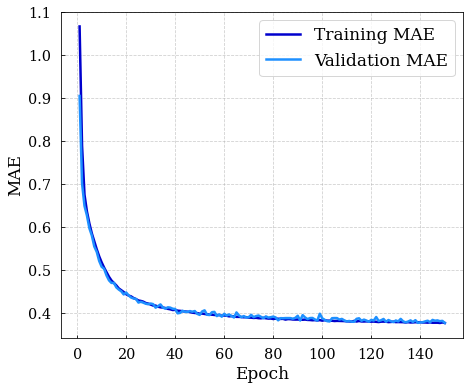

In [14]:
# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot MAE
plt.plot(Epochs_sp, train_mae, c = 'mediumblue',linewidth=2.5,label='Training MAE')
plt.plot(Epochs_sp, val_mae, c = 'dodgerblue',linewidth=2.5,label='Validation MAE')

# ==========================================
# ==========================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epoch', fontsize=17);plt.ylabel('MAE',fontsize=17)
plt.legend(frameon=True, loc='upper right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

#plt.xlim(20,)
#plt.ylim(0.1,0.4)
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/MAE.pdf")
#files.download("/content/drive/My Drive/BNN_Final_Codes/Plots/MAE.pdf")
plt.show()